<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Построим модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Нам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders`.

## Подготовка

In [1]:
# Загрузим все необходимые библиотеки:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.model_selection import train_test_split
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error
import warnings 
warnings.filterwarnings('ignore')

In [2]:
# Выведем данные:
data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])

# Выведем все необходимые характеристики данных:
def analize(table):
    display(table.info())
    display(table.head())
    display(table.describe())
    print('Хронологический порядок даты и времени:', table.index.is_monotonic)

analize(data)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


None

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


Хронологический порядок даты и времени: True


Пропусков нет. Данные в хронологическом порядке.

## Анализ

<AxesSubplot:xlabel='datetime'>

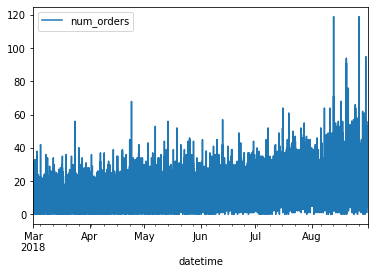

In [3]:
# Построим график из имеющихся данных:
data.plot()

В августе больше всего заказов.

<AxesSubplot:xlabel='datetime'>

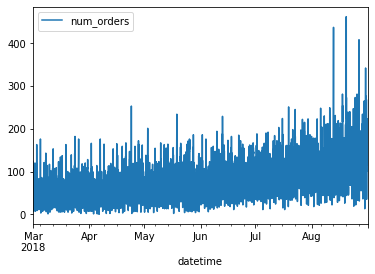

In [4]:
# Проведем ресемплирование данных по одному часу:
data = data.resample('1H').sum()
data.plot()

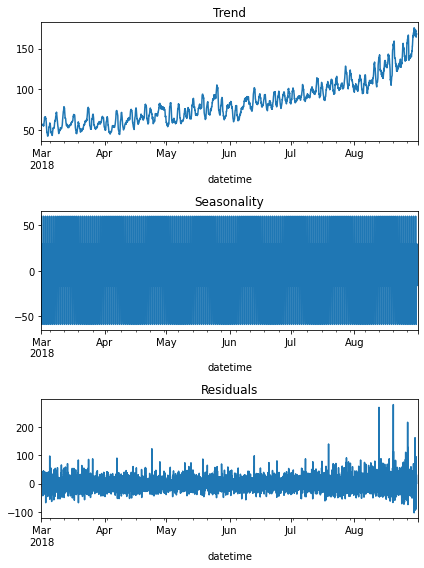

In [5]:
# Разложим временной ряд на тренд и сезонную компоненту:
decomposed = seasonal_decompose(data)

plt.figure(figsize=(6, 8))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

**Вывод:** В наличии возрастающий тренд, особенно в августе, и сезонность изменения числа заказов.

Выделим два вида сезонности в данных:
* дневная сезонность - по дням недели,
* внутрисуточная сезонность - утро, день или вечер.

<AxesSubplot:xlabel='datetime'>

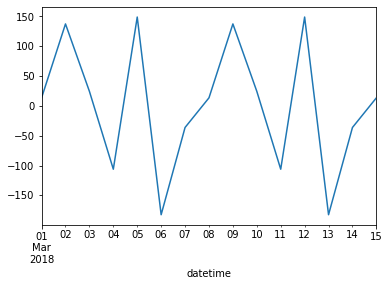

In [6]:
# Посмотрим на дневную сезонность на более коротком периоде - 2 недели по дням:
data_1D = data.resample('1D').sum()

decomposed = seasonal_decompose(data_1D)

decomposed.seasonal['2018-03-01':'2018-03-15'].plot()

Можно отметить здесь пиковые значения заказов такси по пятницам и понедельникам.

<AxesSubplot:xlabel='datetime'>

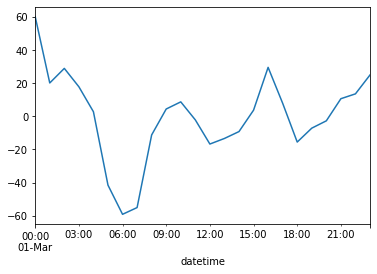

In [7]:
# Посмотрим на суточную сезонность на периоде - одного дня:
data_1H = data.resample('1H').sum()

decomposed = seasonal_decompose(data_1H)

decomposed.seasonal['2018-03-01':'2018-03-01'].plot()

Ночью и в обед спад в заказах, пик заказов утром с 8 до 10, вечером с 15 до 18, и поздним вечером с 21 до 24.

**Выводы:** Данные есть только с марта по сентябрь 2018. Сезонность можно рассмотреть только по дням недели и времени суток. На графиках присутствует сезонность по дням недели - больше всего заказов по пятницам и понедельникам, а также дневная сезонность утром, вечером и поздним вечером.

## Обучение

In [9]:
# Напишем функцию для создания признаков для горизонта прогнозирования в один шаг:
def make_features(data, max_lag, rolling_mean_size):
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()


make_features(data, 1, 24)
data.head()

,num_orders,dayofweek,hour,lag_1,rolling_mean
datetime,,,,,
2018-03-01 00:00:00,124,3,0,NaN,NaN
2018-03-01 01:00:00,85,3,1,124.0,NaN
2018-03-01 02:00:00,71,3,2,85.0,NaN
2018-03-01 03:00:00,66,3,3,71.0,NaN
2018-03-01 04:00:00,43,3,4,66.0,NaN


In [10]:
# Выделим тестовую выборку в размере 10% от датасета:
train, test = train_test_split(data, test_size=0.2, shuffle=False)
train = train.dropna()

print(train.shape)
print(test.shape)

(3508, 5)
(884, 5)


In [11]:
# Выделим признаки и целевой признак в выборках:
features_train = train.drop('num_orders', axis=1)
target_train = train['num_orders']
features_test = test.drop('num_orders', axis=1)
target_test = test['num_orders']

In [12]:
# Обучим модель LinearRegression:
start_time = time.time()
reg = LinearRegression()
reg.fit(features_train,target_train)
end_time = time.time()
time_LR = end_time - start_time

In [13]:
# Обучим модель RandomForestRegressor:
start_time = time.time()
 
reg_RF = RandomForestRegressor(random_state=12345)
parameters = { 'n_estimators': range (10, 51, 10),
              'max_depth': range (1,13, 2) }
tscv = TimeSeriesSplit(n_splits=8)

grid_RF = GridSearchCV(reg_RF, parameters, cv=tscv, scoring='neg_mean_squared_error') 
grid_RF.fit(features_train, target_train)
end_time = time.time()
time_RF = end_time - start_time

print('Лучшие параметры:', grid_RF.best_params_)
print('Время обучения:', time_RF)

Лучшие параметры: {'max_depth': 11, 'n_estimators': 50}
Время обучения: 24.39370059967041


In [14]:
# Обучим модель LGBMRegressor:
start_time = time.time()

reg_LGBM = LGBMRegressor(random_state=12345)
parameters = [{'num_leaves':[10,50,75],
              'learning_rate':[0.1,0.3,0.5]}]
tscv = TimeSeriesSplit(n_splits=8)

grid_LGBM = GridSearchCV(reg_LGBM, parameters, cv=tscv, scoring='neg_mean_squared_error')
grid_LGBM.fit(features_train, target_train)
end_time = time.time()
time_LGBM = end_time - start_time
print('Лучшие гиперпараметры:', grid_LGBM.best_params_)
print('Время обучения:', time_LGBM)

Лучшие гиперпараметры: {'learning_rate': 0.1, 'num_leaves': 10}
Время обучения: 14482.097421646118


## Тестирование

In [23]:
# Измерим метрику RMSE на модели LinearRegression:
start_time = time.time()
pred_test_LR = reg.predict(features_test)
end_time = time.time()
time_LR_pred = end_time - start_time
RMSE_LR = np.sqrt(mean_squared_error(target_test, pred_test_LR))
print('Метрика RMSE LinearRegression:', RMSE_LR)
print('Время обучения:', time_LR)
print('Время предсказания:', time_LR_pred)

Метрика RMSE LinearRegression: 46.55159819817629
Время обучения: 0.005749940872192383
Время предсказания: 0.004611968994140625


In [16]:
# Измерим метрику RMSE на модели RandomForestRegressor:
start_time = time.time()
pred_test_RF = grid_RF.predict(features_test)
end_time = time.time()
time_RF_pred = end_time - start_time
RMSE_RF = np.sqrt(mean_squared_error(target_test, pred_test_RF))
print('Метрика RMSE RandomForestRegressor:', RMSE_RF)
print('Время обучения:', time_RF)
print('Время предсказания:', time_RF_pred)

Метрика RMSE RandomForestRegressor: 46.268295863094856
Время обучения: 24.39370059967041
Время предсказания: 0.07344222068786621


In [17]:
# Измерим метрику RMSE на модели LightGBM:
start_time = time.time()
predictions_test_LGBM = grid_LGBM.predict(features_test)
end_time = time.time()
time_LGBM_pred = end_time - start_time
RMSE_LightGBM = np.sqrt(mean_squared_error(target_test, predictions_test_LGBM))
print('Метрика RMSE LightGBM:', RMSE_LightGBM)
print('Время обучения:', time_LGBM)
print('Время предсказания:', time_LGBM_pred)

Метрика RMSE LightGBM: 45.6572407333329
Время обучения: 14482.097421646118
Время предсказания: 0.019479036331176758


In [18]:
# Используем DummyRegressor для проверки моделей на адекватность:
start_time = time.time()
dummy_reg = DummyRegressor()
dummy_reg.fit(features_train, target_train)
end_time = time.time()
time_DR = end_time - start_time

start_time = time.time()
dummy_pred = dummy_reg.predict(features_test)
end_time = time.time()
time_DR_pred = end_time - start_time
RMSE_DR = np.sqrt(mean_squared_error(target_test, dummy_pred))
print('Метрика RMSE DummyRegressor:', RMSE_DR)
print('Время обучения:', time_DR)
print('Время предсказания:', time_DR_pred)

Метрика RMSE DummyRegressor: 74.3390364639017
Время обучения: 0.0009074211120605469
Время предсказания: 0.0008673667907714844


In [19]:
# Соберем полученные данные в единую таблицу:
metrics = pd.DataFrame({'model':['LinearRegression', 'RandomForestRegressor', 'LightGBM', 'DummyRegressor'],
                       'RMSE':[RMSE_LR, RMSE_RF, RMSE_LightGBM, RMSE_DR],
                       'Time to learn':[time_LR, time_RF, time_LGBM, time_DR],
                       'Time to predict':[time_LR_pred, time_RF_pred, time_LGBM_pred, time_DR_pred]})

display(metrics.sort_values(by=['RMSE']).reset_index(drop=True))

,model,RMSE,Time to learn,Time to predict
0,LightGBM,45.657241,14482.097422,0.019479
1,RandomForestRegressor,46.268296,24.393701,0.073442
2,LinearRegression,46.551598,0.005750,0.002973
3,DummyRegressor,74.339036,0.000907,0.000867


**Выводы:**
* Метрика RMSE модели LightGBM имеет лучше значение 45,7 и ниже значения 48 - данная модель лучше всего отработала.

Text(0, 0.5, 'Число заказов')

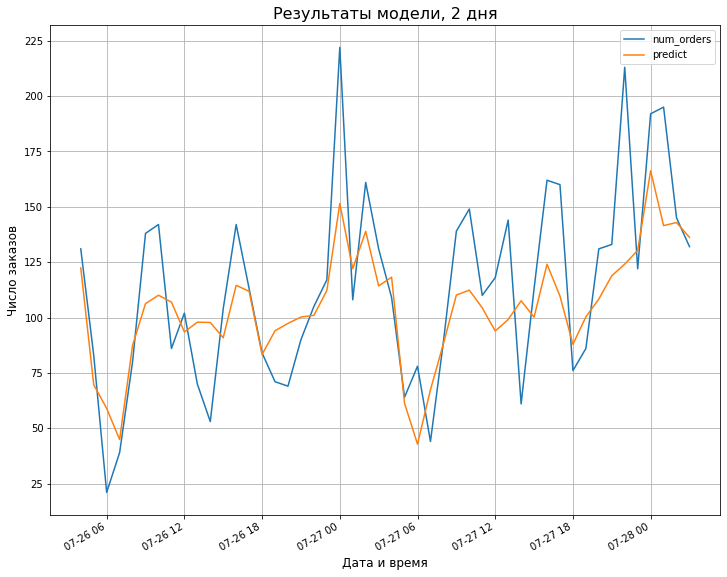

In [63]:
# Построим графики факт/предсказанное на одном рисунке:
target = pd.DataFrame(target_test[0:884])
target['predict'] = predict.tolist()
target[0:48].plot(grid = True, figsize=(12, 10))
plt.title("Результаты модели, 2 дня", fontsize=16)
plt.xlabel("Дата и время", fontsize=12)
plt.ylabel("Число заказов", fontsize=12)